# Comprehensive Modeling Notebook
### In place of creating 3 key models, a 33% baseline random guess is established, then a simple sequential CNN is created, and finally a grid search is performed to establish the best model hyperparameters

1. Spectrogram import and pre-processing
    - Create pre-processing functions
    - Instantiate ImageDataGenerators for train, validate, and test sets
    - Access train, validate, and test folders for the pre-split spectrograms
    - Apply pre-processing: rescaling, intensity flips, and frequency/time masking
2. Visualize example training and validation data
3. CNN Grid Search - Up to 24 models at once
    - Vary the following parameters: activation function, batch size, kernel size, learning rate, optimizer
    - Export evaluation validation accuracy and loss, number of epochs, and model paramters to .json file
4. Train grid search-selected model
    - Train selected model on train and validation set
        - Show train and validation loss and accuracy at each epoch
    - Test model on test set
        - Return confusion matrix and accuracy
    - Save model to *.h5* file
5. Create 3D model visualization and save file
6. In future: plotting loss and other metrics

### What can/should be tested in the grid search?

- Image resolution - **img_width**, **img_height**
- Learning rate - **lr**
- Activation function - **activation**
- Batch size (for ImageDataGenerator and CNN separately) - **batch_size**
- Kernel size - **kernel_size**
- Optimizer - **optimizer**
- Time and Frequency masking dimensions - **T**, **F**
- Full, half, or quarter song spectrograms

### Imports

In [112]:
# Visualization
import matplotlib.pyplot as plt
import visualkeras
import PIL
from PIL import Image
from PIL import ImageFont
import seaborn as sns

# Standard Packages
import numpy as np
import warnings
import pandas as pd
import os
import shutil
import random
import time
import json

# ML Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, ParameterGrid
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, \
                                    Dense, concatenate, Dropout, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Additional Settings
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

## 1. Spectrogram Import and Pre-Processing

### Preprocessing functions for ImageDataGenerator

In [104]:
def flip_intensity(spec):
    '''
    Flip the intensity values of the image (black to white and flip values inbetween)
    
    Returns modified image
    '''
    
    spec = np.max(spec) - spec
    return spec


def freq_mask(spec, F_min=25, F_max=75, num_masks=1, replace_with_zero=True):
    '''
    Applies frequency mask to spectrogram. A horizontal bar of width between 
    F_min and F_max is placed randomly into the spectrogram
    
    Returns -> modified spectrogram.
    
    spec: Input spectrogram (2D numpy array).
    F_min: The minimum width of each frequency mask.
    F_max: The maximum width of each frequency mask.
    num_masks: The number of frequency masks to apply.
    replace_with_zero: Whether to replace the masked frequencies with zeros or with the mean value of the spectrogram.
    '''
    
    
    cloned = np.copy(spec)
    num_mel_channels = cloned.shape[1]
    
    for i in range(0, num_masks):       
        f = random.randrange(F_min, F_max)                     # min to max width of the mask
        f_zero = random.randrange(0, num_mel_channels - f)
        
        # avoids randrange error if values are equal and range is empty
        if (f_zero == f_zero + f): 
            return cloned
        
        mask_end = random.randrange(f_zero, f_zero + f) 
        if (replace_with_zero):
            cloned[:, f_zero:mask_end] = 0
        else:
            cloned[:, f_zero:mask_end] = cloned.mean()
    
    return cloned


def time_mask(spec, T_min=25, T_max=75, num_masks=1, replace_with_zero=True):
    '''
    Applies time mask to spectrogram. A vertical bar of width between 
    T_min and T_max is placed randomly into the spectrogram
    
    Returns -> modified spectrogram.    
    
    spec: Input spectrogram (2D numpy array).
    T_min: The minimum width of each time mask.
    T_max: The maximum width of each time mask.
    num_masks: The number of time masks to apply.
    replace_with_zero: Whether to replace the masked time steps with zeros or with the mean value of the spectrogram.
    '''
    
    cloned = np.copy(spec)
    len_spectro = cloned.shape[0]
    
    for i in range(0, num_masks):
        t = random.randrange(T_min, T_max)                      # min to max width of the mask
        t_zero = random.randrange(0, len_spectro - t)
        
        # avoids randrange error if values are equal and range is empty
        if (t_zero == t_zero + t):
            return cloned
        
        mask_end = random.randrange(t_zero, t_zero + t)
        if (replace_with_zero):
            cloned[t_zero:mask_end, :] = 0
        else:
            cloned[t_zero:mask_end, :] = cloned.mean()
    return cloned


def sc(spec: np.ndarray):
    '''
    Pre-processing function for the images loaded in by ImageDataGenerator.
    Flips intensity of image values and applies time and frequency masking
    '''
    
    spec = flip_intensity(spec)
    spec = freq_mask(spec)
    spec = time_mask(spec)
    return spec


### Create ImageDataGenerators for Train, Validation, and Test sets

Notes:
- Applies rescaling of 1/255.
- Only masking time and frequency of training set so that testing is effective on full songs. 
- Applying intensity flip to all images so that the max values are where the decibel value is highest.

Source images have dimensions 6840x6840. Smaller import dimensions must be selected because these images are high resolution with large file sizes and cause the model to have lengthy training. We have selected 512x512 as the default for modeling, but 256x256 and 1024x1024 are also effective.

Set relevant parameters

In [110]:
generator_batch_size = 16
img_height = 512
img_width = 512
num_channels = 1  # It is grayscale. RGB would be 3
input_shape = (img_height, img_width, num_channels)


# Set the root directory containing the subdirectories for the selected dataset
root_dir = '../spectrograms/high_res/full/'

# Create the train, validation, and test directories
train_dir = root_dir + 'train/'
val_dir = root_dir + 'validate/'
test_dir = root_dir + 'test/'

Create ImageDataGenerators

In [106]:
train_data_gen = ImageDataGenerator(preprocessing_function=sc, rescale=1./255).flow_from_directory(
        directory=train_dir,
        target_size=(img_height, img_width),
        color_mode='grayscale',
        batch_size=generator_batch_size,
        class_mode='categorical',
        seed=123
)

validation_data_gen = ImageDataGenerator(preprocessing_function=flip_intensity, rescale=1./255).flow_from_directory(
        directory=val_dir,
        target_size=(img_height, img_width),
        color_mode='grayscale',
        batch_size=generator_batch_size,
        class_mode='categorical',
        seed=123
)

test_data_gen = ImageDataGenerator(preprocessing_function=flip_intensity, rescale=1./255).flow_from_directory(
        directory=test_dir,
        target_size=(img_height, img_width),
        color_mode='grayscale',
        batch_size=generator_batch_size,
        class_mode='categorical',
        seed=123
)

Found 210 images belonging to 3 classes.
Found 45 images belonging to 3 classes.
Found 45 images belonging to 3 classes.


## 2. Visualize Example Training and Validation Data

Train images will have time and frequency masks. Validation will not.

### Training Data Example

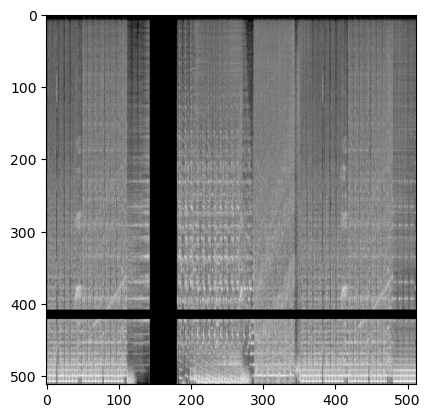

The image shape is: (16, 512, 512, 1)


In [108]:
img, label = train_data_gen.next()
plt.imshow(img[0], cmap='gray')
plt.show()

print('The image shape is: ' + str(img.shape))   #  (1,256,256,3)

### Validation Data Example

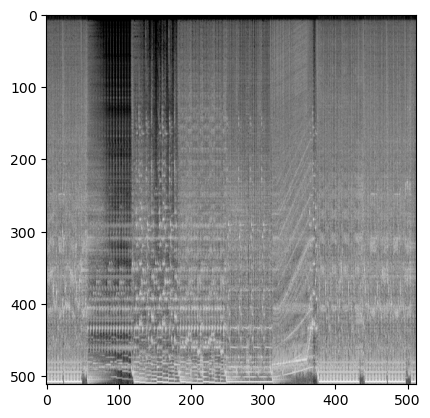

The image shape is: (16, 512, 512, 1)


In [109]:
img, label = validation_data_gen.next()
plt.imshow(img[0], cmap='gray')
plt.show()

print('The image shape is: ' + str(img.shape))   #  (1,256,256,3)

### Save and load model code

In [16]:
# model.save('../models/' + model_file_name)              # As .h5 file
# saved_model = load_model('../models/' + model_file_name)

## 3. CNN Grid Search - Up to 24 Models at Once

### Function that creates and returns the model given a set of hyperparameters

In [13]:
def create_model(learning_rate=0.001, optimizer='adam', kernel_size=(3,3), activation='relu', batch_size=16):
    
    ### Create Sequential Model ###
    model = Sequential([
                Conv2D(32, kernel_size, activation=activation, input_shape=input_shape), 
                MaxPooling2D((2, 2)),
                Conv2D(64, kernel_size, activation=activation),
                MaxPooling2D((2, 2)),
                Conv2D(64, (4, 4), activation='relu'), # Making the last kernel_size large to capture bigger features
                MaxPooling2D(pool_size=(2, 2)),
                Flatten(),
                Dense(128, activation=activation),
                Dropout(0.5),
                Dense(3, activation='softmax')
            ])
    
    ### Compile the Model ###
    model.compile(
               optimizer=optimizer(learning_rate=learning_rate),
               loss='categorical_crossentropy',
               metrics=['accuracy']
            )
    
    return model

### Define Grid Search Parameters

Additional hyperparamter options are commented out

In [14]:
param_grid = dict(
    learning_rate=[1e-3, 5e-4],                   # 1e-4
    optimizer=[tf.keras.optimizers.Adam],         # tf.keras.optimizers.SGD
    kernel_size=[(2,2), (3,3), (4,4)],
    activation=['relu'],                          # 'tanh'
    batch_size=[16, 32]
                                                  # metrics = ['accuracy', 'precision']
                                                  # stride = 2
)

### Perform Grid Search

A loop that iterates through every combination of parameters in a parameter dictionary and does the following:
1. Creates and fits (trains) the model
2. Evaluates the model via validation accuracy and loss
3. Appends a results dictionary with the validation loss and accuracy, parameter values, and number of epochs
4. Write the results to a .json file for later use

In [16]:
results_full = {}     # Dictionary that stores grid search results for each set of params

for params in ParameterGrid(param_grid):

    # Create the model
    model = create_model(learning_rate=params['learning_rate'], optimizer=params['optimizer'], 
                         kernel_size=params['kernel_size'], batch_size=params['batch_size'])
    
    
    # Instantiate EarlyStopping to end model training
    early_stop = EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=5)
    
    
    history_full = model.fit_generator(
        train_data_gen,
        steps_per_epoch=train_data_gen.samples // params['batch_size'],
        epochs=100,
        validation_data=validation_data_gen,
        validation_steps=validation_data_gen.samples // params['batch_size'],
        workers=8,
        callbacks=[early_stop],
        verbose=0
    )
    
    # Evaluate the model on the validation data and print the results
    val_loss, val_acc = model.evaluate_generator(validation_data_gen, verbose=0, workers=8,
                                                steps=validation_data_gen.samples // params['batch_size'])
    
    
    # Get the number of epochs the model ran
    num_epochs = len(history_full.history['loss'])
    
    
    # Get string representation of the parameters to use in dictionary key
    o = 'adam' if 'Adam' in str(params['optimizer']) else 'sgd'
    
    
    # Create dictionary key that includes all the hyperparameters in a string
    p = params['activation'] + '_' + str(params['batch_size']) + '_' + str(params['kernel_size']) \
    + '_' + str(params['learning_rate']) + '_' + o
    
    
    # Print out the performance of the current model with its params
    print('Params: {} \n Validation Loss: {:.3f}, Validation Accuracy: {:.3f}, Epochs: {}'.format(params, val_loss, 
                                                                                                  val_acc, num_epochs))
    
    
    # Add these results to the results dictionary (includes val_loss, val_acc, and params)
    params['optimizer'] = o        # Makes sure that the params value is serializable to save to json file
    results_full[p] = {'val_loss': val_loss, 'val_acc': val_acc, 'epochs' : num_epochs, 'params_dict' : params}

    
    # write the results to file after each iteration
    with open("grid_search_results_full_extra_layer.json", "w") as f:
        json.dump(results_full, f, indent=4)


--------------------------------------------------------------------------------------------


2023-04-16 21:49:02.831181: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Params: {'activation': 'relu', 'batch_size': 16, 'kernel_size': (2, 2), 'learning_rate': 0.001, 'optimizer': <class 'keras.optimizers.optimizer_experimental.adam.Adam'>} 
 Validation Loss: 1.099, Validation Accuracy: 0.281, Epochs: 12
--------------------------------------------------------------------------------------------
Params: {'activation': 'relu', 'batch_size': 16, 'kernel_size': (2, 2), 'learning_rate': 0.0005, 'optimizer': <class 'keras.optimizers.optimizer_experimental.adam.Adam'>} 
 Validation Loss: 0.945, Validation Accuracy: 0.656, Epochs: 19
--------------------------------------------------------------------------------------------
Params: {'activation': 'relu', 'batch_size': 16, 'kernel_size': (3, 3), 'learning_rate': 0.001, 'optimizer': <class 'keras.optimizers.optimizer_experimental.adam.Adam'>} 
 Validation Loss: 1.099, Validation Accuracy: 0.281, Epochs: 9
--------------------------------------------------------------------------------------------
Params: {'activa

### Open and view results from JSON file and get best params

Open JSON File

In [19]:
with open('grid_search_results_full_extra_layer.json') as f:
    loaded_results = json.load(f)

#### Get the best parameters from the results dictionary

In [20]:
best_params = max(loaded_results, key=lambda x: loaded_results[x]['val_acc'])
print('The best parameter results are: ')
loaded_results[best_params]

{'val_loss': 0.47177743911743164,
 'val_acc': 0.75,
 'epochs': 10,
 'params_dict': {'activation': 'relu',
  'batch_size': 16,
  'kernel_size': [4, 4],
  'learning_rate': 0.0005,
  'optimizer': 'adam'}}

## 4. Train Grid Search-Selected Model

### Create model

Set model hyperparameters

In [21]:
kernel_size = (4, 4)
lr = 0.5e-3
activation = 'relu'
batch_size = 16

Create sequential model

In [22]:
model_best = Sequential([Conv2D(32, kernel_size, activation=activation, input_shape=input_shape), 
                    MaxPooling2D((2, 2)),
                    Conv2D(64, kernel_size, activation=activation),
                    MaxPooling2D((2, 2)),
                    Conv2D(64, (4, 4), activation='relu'),
                    MaxPooling2D(pool_size=(2, 2)),
                    Flatten(),
                    Dense(128, activation=activation),
                    Dropout(0.5),
                    Dense(3, activation='softmax')])

View model summary

In [30]:
model_best.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 509, 509, 32)      544       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 254, 254, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 251, 251, 64)      32832     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 125, 125, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 122, 122, 64)      65600     
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 61, 61, 64)     

Compile model

In [23]:
model_best.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# Optional loss function: tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

Create EarlyStopping to end model training

In [24]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=5)

Fit model

In [25]:
start_time = time.time()
history_best = model_best.fit_generator(
        train_data_gen,
        steps_per_epoch=train_data_gen.samples // batch_size,
        epochs=100,
        validation_data=validation_data_gen,
        validation_steps=validation_data_gen.samples // batch_size,
        workers=8,
        callbacks=[early_stop]
)
print(time.time() - start_time)

Epoch 1/100
13/13 [==============================] - 48s 3s/step - loss: 1.5105 - accuracy: 0.3041 - val_loss: 1.0981 - val_accuracy: 0.3125
Epoch 2/100
13/13 [==============================] - 45s 4s/step - loss: 1.0985 - accuracy: 0.3866 - val_loss: 1.0517 - val_accuracy: 0.4375
Epoch 3/100
13/13 [==============================] - 44s 2s/step - loss: 1.0713 - accuracy: 0.3608 - val_loss: 0.9721 - val_accuracy: 0.6875
Epoch 4/100
13/13 [==============================] - 44s 2s/step - loss: 0.9761 - accuracy: 0.5155 - val_loss: 0.9196 - val_accuracy: 0.5000
Epoch 5/100
13/13 [==============================] - 45s 2s/step - loss: 0.9444 - accuracy: 0.5052 - val_loss: 0.6903 - val_accuracy: 0.7188
Epoch 6/100
13/13 [==============================] - 44s 2s/step - loss: 0.7614 - accuracy: 0.6289 - val_loss: 0.7506 - val_accuracy: 0.6250
Epoch 7/100
13/13 [==============================] - 44s 2s/step - loss: 0.9006 - accuracy: 0.5464 - val_loss: 0.8796 - val_accuracy: 0.4062
Epoch 8/100
1

### Test model on test set

In [26]:
# Get the predictions for the test set
test_predictions_percentages_best = model_best.predict_generator(test_data_gen, 
                                                                 steps=test_data_gen.samples // batch_size + 1)
test_predictions_best = np.argmax(test_predictions_percentages_best, axis=1)

# Get the true labels for the test set
test_labels = test_data_gen.classes

The accuracy on the test set is: 0.4888888888888889


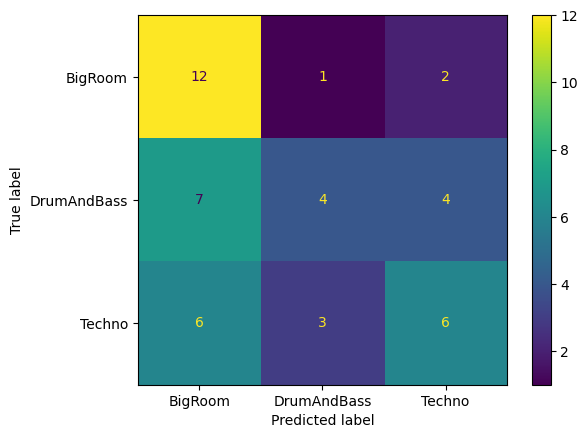

In [27]:
print('The accuracy on the test set is: ' + str(accuracy_score(test_labels, test_predictions_best)))

# Create the confusion matrix
confusion_mtx_best = confusion_matrix(test_labels, test_predictions_best)

# Plot the confusion matrix
disp_best = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx_best, 
                                   display_labels=['BigRoom', 'DrumAndBass', 'Techno'])

# Plot the confusion matrix
disp_best.plot()

### Save model to .h5 file

This allows it to be imported and used in the future

In [29]:
model_file_name = 'relu_16_(4, 4)_0.0005_adam_extra_layer_dimensions_512.h5'
model_best.save('../models/' + model_file_name)              # As .h5 file

## 5. Create 3D Model Visualization and Save PNG File

Text color is currently white so it can be visualized later on a dark background presentation

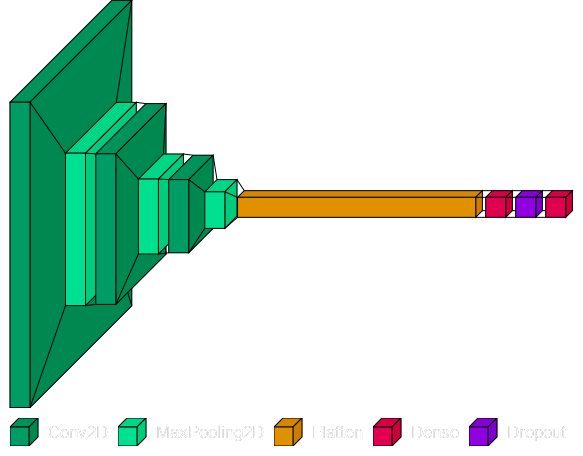

In [101]:
# Get the path to the Mac fonts directory
fonts_dir = '/Library/Fonts'

# Get the path to the Arial font file
font_path = os.path.join(fonts_dir, 'Arial.ttf')

color_map = defaultdict(dict) #customize the colours
color_map[layers.Conv2D]['fill'] = '#009c65'
color_map[layers.MaxPooling2D]['fill'] = '#00e091'
color_map[layers.Dropout]['fill'] = '#9100e0'
color_map[layers.Dense]['fill'] = '#e0004f'
color_map[layers.Flatten]['fill'] = '#e09100'
font = ImageFont.truetype(font_path, 17, )

visualkeras.layered_view(model_best, legend=True,color_map=color_map, scale_xy=.6, scale_z=0.001, background_fill=0, 
                        font=font, font_color='white', to_file='../../CNN_visualization.png') #Optional: font=font

## 6. In future: Plotting Loss and Other Metrics

In [ ]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,21)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'bo',label='Training Loss')
ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()